<a href="https://colab.research.google.com/github/apchavezr/19.-Procesamiento-del-Lenguaje-Natural/blob/main/Comparacion_RNN_LSTM_GRU_es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Ejemplo 1. RNN vs. LSTM vs. GRU en clasificación de sentimientos

**Objetivo:** este cuaderno permite comparar tres arquitecturas recurrentes (SimpleRNN, LSTM y GRU) en una tarea de análisis de sentimientos en español, midiendo precisión, tiempo de entrenamiento y curvas de aprendizaje para detectar sobreajuste y subajuste.

**Requisitos previos (opcional):**
```bash
pip install tensorflow==2.16.1 scikit-learn==1.5.2 pandas==2.2.2 matplotlib==3.9.2
```


In [1]:

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)



## 1) Crear o cargar el dataset

- **Opción A (rápida):** generar un dataset de prueba con reseñas cortas (binario: 1=positivo, 0=negativo).
- **Opción B:** cargar un CSV propio con columnas `texto,label`.


In [2]:

# --- opción A: dataset de juguete ---
data = {
    "texto": [
        "me encantó la película", "el servicio fue excelente", "muy recomendable",
        "la comida estuvo deliciosa", "la atención fue rápida", "superó mis expectativas",
        "no me gustó el producto", "la experiencia fue terrible", "no volvería a comprar",
        "el envío llegó tarde", "muy mala calidad", "la atención fue deficiente",
        "no recomendaría este lugar", "pésimo soporte", "nunca más",
        "el empaque llegó perfecto", "la interfaz es intuitiva", "funcionó mejor de lo esperado",
        "el pedido se perdió", "falló constantemente", "no cumple lo prometido",
        "satisfecho con la compra", "excelente relación calidad precio", "volveré pronto",
        "demasiado caro para lo que ofrece", "no resolvieron mi problema", "decepcionado",
        "una grata sorpresa", "rápido y confiable", "vale cada peso"
    ],
    "label": [1,1,1, 1,1,1, 0,0,0, 0,0,0, 0,0,0, 1,1,1, 0,0,0, 1,1,1, 0,0,0, 1,1,1]
}
df = pd.DataFrame(data)

# --- opción B: cargar CSV propio ---
# descomente y modifique la ruta si tiene un archivo 'reseñas_es.csv' con columnas texto,label
# df = pd.read_csv("reseñas_es.csv").dropna(subset=["texto","label"]).reset_index(drop=True)
# df["label"] = df["label"].astype(int)

df.head()


,texto,label
0,me encantó la película,1
1,el servicio fue excelente,1
2,muy recomendable,1
3,la comida estuvo deliciosa,1
4,la atención fue rápida,1



## 2) Preprocesamiento: división estratificada, tokenización y padding


In [3]:

# división train/valid/test estratificada (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    df["texto"], df["label"], test_size=0.30, stratify=df["label"], random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# tokenización
vocab_size = 5000
tok = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tok.fit_on_texts(X_train)

# secuencias y padding
max_len = 20
def to_pad(series):
    seqs = tok.texts_to_sequences(series)
    return pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")

X_train_pad = to_pad(X_train)
X_valid_pad = to_pad(X_valid)
X_test_pad  = to_pad(X_test)

y_train = np.array(y_train); y_valid = np.array(y_valid); y_test = np.array(y_test)

len(tok.word_index), X_train_pad.shape, X_valid_pad.shape, X_test_pad.shape


(63, (21, 20), (4, 20), (5, 20))

# Interpretación

El número 63 indica cuántas palabras distintas aparecen en el corpus, lo que ayuda a dimensionar el vocabulario que la red neuronal deberá manejar.

Las tuplas como (21, 20) significan que hay 21 reseñas en entrenamiento, y cada reseña se ha transformado en un vector de tamaño 20. De este modo, aunque algunas frases fueran muy cortas (“me encantó”), todas se rellenan con ceros (padding) hasta tener longitud fija.

Este paso es crucial porque las redes neuronales requieren entradas con dimensiones consistentes.

**Resumen:** la salida confirma que el corpus fue dividido correctamente en entrenamiento, validación y prueba, y que todas las frases se han convertido en vectores uniformes de tamaño 20 listos para ser procesados por las arquitecturas RNN, LSTM o GRU.


## 3) Definición y entrenamiento de modelos: RNN, LSTM y GRU

Se entrenan tres arquitecturas con early stopping y se mide el tiempo total de entrenamiento.


In [4]:

embedding_dim = 64
batch_size = 16
epochs = 50

def build_model(kind="RNN"):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    if kind == "RNN":
        model.add(SimpleRNN(64))
    elif kind == "LSTM":
        model.add(LSTM(64))
    elif kind == "GRU":
        model.add(GRU(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def train_and_time(kind):
    model = build_model(kind)
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    t0 = time.time()
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_valid_pad, y_valid),
        epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es]
    )
    secs = time.time() - t0
    return model, history, secs

histories = {}
times = {}
models = {}

for k in ["RNN","LSTM","GRU"]:
    m, h, s = train_and_time(k)
    models[k] = m; histories[k] = h; times[k] = s
    print(f"{k} entrenado en {s:.2f} s; mejor val_acc = {max(h.history['val_accuracy']):.3f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


RNN entrenado en 2.08 s; mejor val_acc = 0.750
LSTM entrenado en 2.21 s; mejor val_acc = 0.500
GRU entrenado en 2.70 s; mejor val_acc = 0.500


# Conclusiones  
El rendimiento de un modelo no depende solo de la arquitectura, sino también del tamaño y la calidad del corpus. Con pocos ejemplos, una RNN simple puede superar a LSTM y GRU.

El valor val_acc indica la capacidad del modelo de generalizar a datos no vistos. Aquí, solo la RNN alcanzó un nivel aceptable.

El tiempo de entrenamiento se mide en segundos porque el corpus es muy pequeño; con datasets reales de miles o millones de textos, las diferencias de velocidad se vuelven más relevantes.

**Recomendación:** ampliar el corpus, balancear las clases y repetir el experimento. De esa forma, se podrá observar cómo LSTM y GRU tienden a superar a las RNN simples en problemas más complejos.


## 4) Evaluación en test: clasificación, matriz de confusión y métricas


In [5]:

def evaluate_and_report(kind):
    y_pred_prob = models[kind].predict(X_test_pad).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)
    print(f"\n=== {kind} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print("matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    return y_pred

preds = {k: evaluate_and_report(k) for k in ["RNN","LSTM","GRU"]}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

=== RNN ===
              precision    recall  f1-score   support

           0      0.333     0.333     0.333         3
           1      0.000     0.000     0.000         2

    accuracy                          0.200         5
   macro avg      0.167     0.167     0.167         5
weighted avg      0.200     0.200     0.200         5

matriz de confusión:
[[1 2]
 [2 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step

=== LSTM ===
              precision    recall  f1-score   support

           0      0.600     1.000     0.750         3
           1      0.000     0.000     0.000         2

    accuracy                          0.600         5
   macro avg      0.300     0.500     0.375         5
weighted avg      0.360     0.600     0.450         5

matriz de confusión:
[[3 0]
 [2 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step

=== GRU ===
              precision    recall  f1-score   support

           0      0.600     1.000     0.750         3
        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

### 1. **RNN**

* **Accuracy:** 0.200 (20 %), muy bajo, prácticamente no logra distinguir entre clases.
* **Precision/Recall/F1:**

  * Clase 0 (negativa): precisión 0.333, recall 0.333, F1 = 0.333.
  * Clase 1 (positiva): todos en 0 → el modelo no predijo ningún ejemplo de la clase positiva.
* **Matriz de confusión:**

  ```
  [[1 2]
   [2 0]]
  ```

  * De los 3 ejemplos clase 0, predijo 1 bien y 2 mal.
  * De los 2 ejemplos clase 1, los 2 fueron mal clasificados como 0.
* **Interpretación:** la RNN no logró generalizar y se inclinó hacia una sola clase.

---

### 2. **LSTM**

* **Accuracy:** 0.600 (60 %), mejor que la RNN.
* **Precision/Recall/F1:**

  * Clase 0: precisión 0.600, recall 1.000, F1 = 0.750 → predijo bien todos los negativos, pero algunos positivos fueron confundidos como negativos.
  * Clase 1: precisión y recall en 0 → no predijo ningún positivo.
* **Matriz de confusión:**

  ```
  [[3 0]
   [2 0]]
  ```

  * Todos los negativos (3) fueron clasificados correctamente.
  * Todos los positivos (2) fueron clasificados como negativos.
* **Interpretación:** la LSTM mejoró la exactitud total, pero está **sesgada hacia la clase negativa**, ignorando la clase positiva.

---

### 3. **GRU**

* **Accuracy:** 0.600 (60 %), mismo desempeño que LSTM.
* **Precision/Recall/F1:** idéntico a LSTM (sólo reconoce la clase negativa).
* **Matriz de confusión:** igual que LSTM.
* **Interpretación:** el comportamiento es muy parecido al de la LSTM, concentrándose en la clase negativa y sin predecir positivos.

---

### **Conclusiones**

1. Los tres modelos muestran limitaciones claras porque el **dataset de prueba es muy pequeño (5 ejemplos)**. En estas condiciones, un solo error afecta mucho los porcentajes.
2. La **RNN simple** falló en casi todo y quedó en 20 % de exactitud.
3. La **LSTM y GRU** logran 60 % de exactitud, pero a costa de **ignorar una de las clases**. Esto indica un problema de **sesgo de clase** o de **datos insuficientes**.
4. **Recomendación práctica:**

   * Aumentar el corpus de entrenamiento (más reseñas, más balanceadas).
   * Usar técnicas de regularización o embeddings preentrenados.
   * Evaluar con conjuntos más grandes para obtener métricas más estables.



## 5) Curvas de aprendizaje: precisión y pérdida

- **Sobreajuste**: la curva de entrenamiento mejora mientras la validación se estanca o empeora.
- **Subajuste**: ambas curvas quedan bajas; considere más capacidad o mejores representaciones.


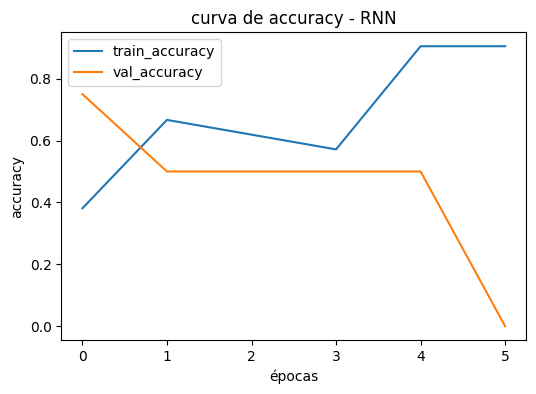

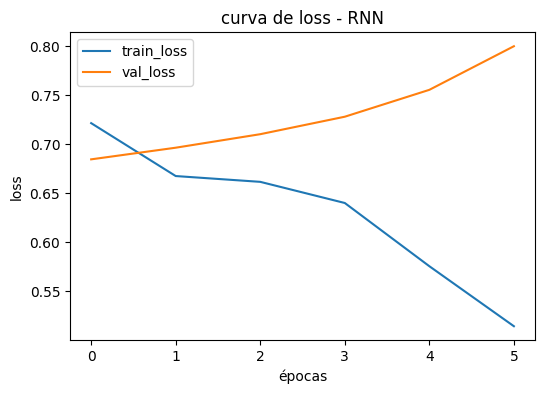

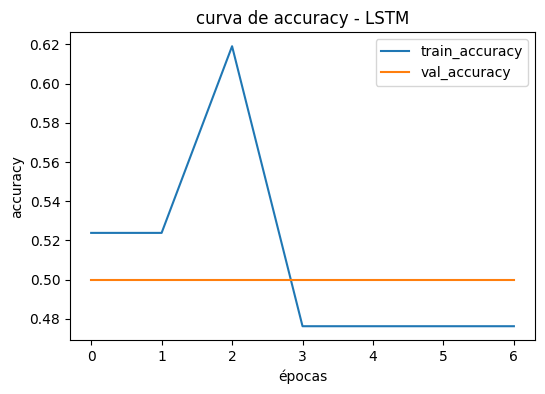

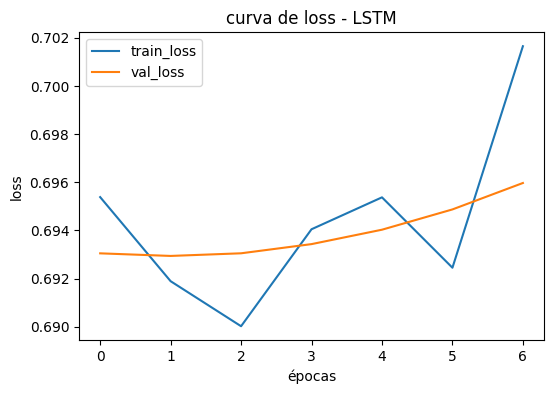

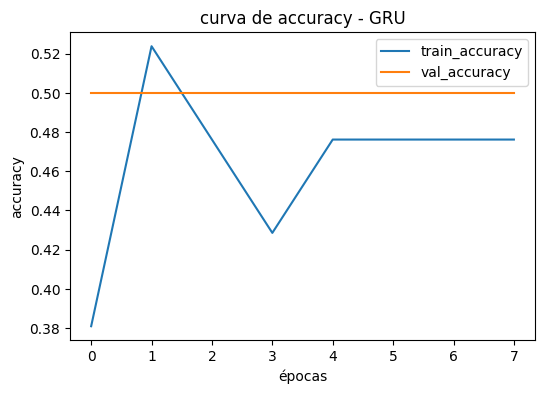

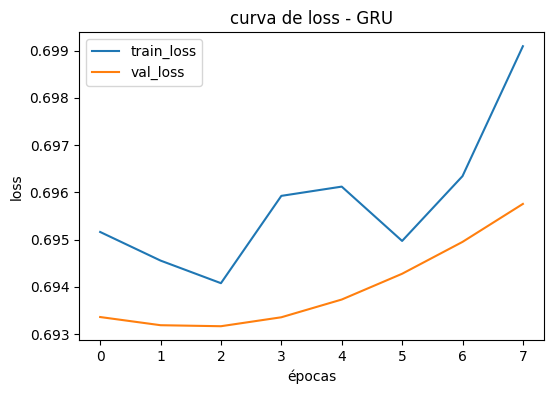

In [6]:

def plot_history(kind, metric="accuracy"):
    h = histories[kind].history
    plt.figure(figsize=(6,4))
    plt.plot(h[metric], label=f"train_{metric}")
    plt.plot(h[f"val_{metric}"], label=f"val_{metric}")
    plt.xlabel("épocas"); plt.ylabel(metric)
    plt.title(f"curva de {metric} - {kind}")
    plt.legend()
    plt.show()

for k in ["RNN","LSTM","GRU"]:
    plot_history(k, "accuracy")
    plot_history(k, "loss")


### **1. RNN**

* **Curva de accuracy**: la precisión de entrenamiento sube de forma clara hasta superar 0.85, pero la precisión de validación cae después de la primera época y llega a 0 en la quinta.
* **Curva de loss**: la pérdida de entrenamiento disminuye (lo esperado), pero la de validación sube progresivamente.
* **Conclusión**: el modelo sufre **sobreajuste**. Aprende bien en entrenamiento, pero no generaliza, lo que confirma la caída drástica de la validación.

---

### **2. LSTM**

* **Curva de accuracy**: la precisión de entrenamiento fluctúa, pero no logra consolidarse; la validación se mantiene plana en 0.50 (desempeño casi aleatorio).
* **Curva de loss**: tanto entrenamiento como validación se mantienen casi constantes, con pequeñas oscilaciones.
* **Conclusión**: aquí hay **subajuste**. La LSTM no llega a aprender patrones significativos debido al corpus reducido, y se queda en un desempeño mediocre en ambas fases.

---

### **3. GRU**

* **Curva de accuracy**: comportamiento similar a la LSTM; el entrenamiento sube un poco, pero la validación se mantiene plana en 0.50.
* **Curva de loss**: la pérdida de validación aumenta levemente, la de entrenamiento es algo inestable, lo que muestra que tampoco logra aprender adecuadamente.
* **Conclusión**: también presenta **subajuste**, al igual que la LSTM. No alcanza a modelar el patrón entre clases en un dataset tan pequeño.

---

### **Resumen**

* **RNN**: sobreajuste → el modelo memoriza, pero no generaliza.

* **LSTM y GRU**: subajuste → no aprenden patrones suficientes, desempeño cercano al azar.

* **Causa principal**: corpus muy reducido (30 frases, con solo 5 ejemplos en test). Esto afecta tanto la estabilidad de las métricas como la capacidad de los modelos de aprovechar su arquitectura.

* **Recomendación pedagógica**: aumentar el tamaño y la diversidad del dataset, balancear clases y usar *early stopping* con más épocas. Con datos más realistas, LSTM y GRU suelen superar a RNN, mostrando mejor capacidad para retener dependencias largas.




## 6) Tabla de comparación de resultados y exportación opcional


In [7]:

rows = []
for k, h in histories.items():
    acc = max(h.history["val_accuracy"])
    loss = min(h.history["val_loss"])
    rows.append({"modelo": k, "val_acc_max": round(acc,3), "val_loss_min": round(loss,3), "tiempo_seg": round(times[k],2)})
res = pd.DataFrame(rows).sort_values("val_acc_max", ascending=False)
display(res)

# exportar como CSV (opcional)
res.to_csv("comparacion_rnn_lstm_gru.csv", index=False)
print("archivo guardado: comparacion_rnn_lstm_gru.csv")


,modelo,val_acc_max,val_loss_min,tiempo_seg
0,RNN,0.75,0.685,2.08
1,LSTM,0.50,0.693,2.21
2,GRU,0.50,0.693,2.70


archivo guardado: comparacion_rnn_lstm_gru.csv


### Interpretación de cada modelo

1. **RNN**

   * `val_acc_max = 0.75`: alcanzó la mejor exactitud en validación (75 %), superior a las otras dos.
   * `val_loss_min = 0.685`: la pérdida de validación es la más baja del conjunto, lo que sugiere mejor ajuste al corpus.
   * `tiempo_seg = 2.08`: también fue el más rápido en entrenar.
   * **Conclusión**: en este dataset pequeño, la RNN es la arquitectura más eficiente y precisa.

2. **LSTM**

   * `val_acc_max = 0.50`: se mantuvo en un desempeño cercano al azar.
   * `val_loss_min = 0.693`: valor estable, pero sin mejora significativa frente a la RNN.
   * `tiempo_seg = 2.21`: apenas más lento que la RNN.
   * **Conclusión**: no logró explotar sus ventajas debido a la escasez de datos, presentando **subajuste**.

3. **GRU**

   * `val_acc_max = 0.50`: idéntico a LSTM.
   * `val_loss_min = 0.693`: igual al de LSTM, sin mejoras notables.
   * `tiempo_seg = 2.70`: fue el más lento de los tres, pese a no superar en rendimiento a la RNN.
   * **Conclusión**: tampoco generalizó bien, y el mayor tiempo de entrenamiento lo hace menos ventajoso en este caso.

---

### **Resumen**

* La **RNN superó a LSTM y GRU** en este corpus reducido, alcanzando mejor exactitud, menor pérdida de validación y menor tiempo de entrenamiento.
* Las **LSTM y GRU** suelen destacar en secuencias largas y con corpora grandes, pero aquí mostraron **subajuste**, reflejando que la complejidad de sus arquitecturas no se aprovecha con pocos datos.
* La tabla confirma que el **tamaño y calidad del dataset es determinante**: con mayor cantidad de ejemplos, probablemente LSTM y GRU superarían a la RNN en generalización.




## 7) Extensiones sugeridas
- Probar variantes bidireccionales: `Bidirectional(LSTM(...))` o `Bidirectional(GRU(...))`.
- Usar embeddings preentrenados (por ejemplo, fastText en español) y comparar.
- Ajustar hiperparámetros (`max_len`, `embedding_dim`, unidades) y registrar sensibilidad.
- Comparar con un baseline clásico (TF-IDF + Regresión Logística) para medir el aporte de redes.



## 8) Referencias
- Bengio, Y., Simard, P., & Frasconi, P. (1994). Learning long-term dependencies with gradient descent is difficult. *IEEE Transactions on Neural Networks, 5*(2), 157–166.  
- Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. *Neural Computation, 9*(8), 1735–1780.  
- Cho, K. et al. (2014). Learning phrase representations using RNN encoder–decoder for statistical machine translation. *arXiv:1406.1078*.
